In [3]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
from xml.dom import minidom

# Ensure output directory exists
os.makedirs('LISS-4-Satellite-imagery/output', exist_ok=True)

In [4]:
## 1. Convert AOI KML to GeoJSON

In [5]:
# Parse KML and convert to GeoJSON
kml_path = '../aoi_polygon-1.kml' if not os.path.exists('aoi_polygon-1.kml') else 'aoi_polygon-1.kml'
def kml_to_geojson(kml_path):
    doc = minidom.parse(kml_path)
    coords = doc.getElementsByTagName('coordinates')[0].firstChild.data.strip().split()
    coords = [tuple(map(float, c.split(','))) for c in coords]
    poly = shape({'type': 'Polygon', 'coordinates': [[list(c) for c in coords]]})
    gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs='EPSG:4326')
    return gdf
aoi_gdf = kml_to_geojson(kml_path)
aoi_gdf.to_file('LISS-4-Satellite-imagery/output/aoi.geojson', driver='GeoJSON')
aoi_geom = [mapping(aoi_gdf.geometry[0])]

In [6]:
## 2. Load Bands from LISS4_T1 and LISS4_T2

In [7]:
def load_bands(folder):
    bands = {}
    for b in ['BAND2.tif', 'BAND3.tif', 'BAND4.tif']:
        path = os.path.join(folder, b)
        with rasterio.open(path) as src:
            bands[b] = src.read(1).astype('float32')
            if 'profile' not in bands:
                bands['profile'] = src.profile
    return bands
bands_t1 = load_bands('../LISS4_T1' if not os.path.exists('LISS4_T1') else 'LISS4_T1')
bands_t2 = load_bands('../LISS4_T2' if not os.path.exists('LISS4_T2') else 'LISS4_T2')

In [8]:
## 3. Clip Bands to AOI

In [9]:
def clip_bands(bands, aoi_gdf, folder):
    clipped = {}
    for b in ['BAND2.tif', 'BAND3.tif', 'BAND4.tif']:
        with rasterio.open(os.path.join(folder, b)) as src:
            # Reproject AOI to match raster CRS if needed
            if aoi_gdf.crs != src.crs:
                aoi_gdf_proj = aoi_gdf.to_crs(src.crs)
            else:
                aoi_gdf_proj = aoi_gdf
            aoi_geom_proj = [mapping(aoi_gdf_proj.geometry[0])]
            out_image, out_transform = mask(src, aoi_geom_proj, crop=True)
            clipped[b] = out_image[0]
            if 'profile' not in clipped:
                profile = src.profile.copy()
                profile.update({
                    'height': out_image.shape[1],
                    'width': out_image.shape[2],
                    'transform': out_transform
                })
                clipped['profile'] = profile
    return clipped

clipped_t1 = clip_bands(bands_t1, aoi_gdf, 'LISS4_T1' if os.path.exists('LISS4_T1') else '../LISS4_T1')
clipped_t2 = clip_bands(bands_t2, aoi_gdf, 'LISS4_T2' if os.path.exists('LISS4_T2') else '../LISS4_T2')

In [10]:
## 4. Normalize Bands

In [11]:
def normalize(array):
    arr = array.astype('float32')
    arr_min, arr_max = np.nanmin(arr), np.nanmax(arr)
    return (arr - arr_min) / (arr_max - arr_min + 1e-6)
for b in ['BAND2.tif', 'BAND3.tif', 'BAND4.tif']:
    clipped_t1[b] = normalize(clipped_t1[b])
    clipped_t2[b] = normalize(clipped_t2[b])

In [12]:
## 5. Compute NDVI for Both Images

In [13]:
def compute_ndvi(bands):
    nir = bands['BAND4.tif']
    red = bands['BAND3.tif']
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi
ndvi_t1 = compute_ndvi(clipped_t1)
ndvi_t2 = compute_ndvi(clipped_t2)

In [14]:
## 6. Calculate NDVI Difference

In [15]:
ndvi_diff = ndvi_t2 - ndvi_t1

In [16]:
## 7. Apply Threshold to Detect Change

In [17]:
change_mask = np.abs(ndvi_diff) > 0.3
change_mask_transform = clipped_t1['profile']['transform']  # or wherever your transform is stored

In [34]:
## 8. Visualize NDVI and Change Map

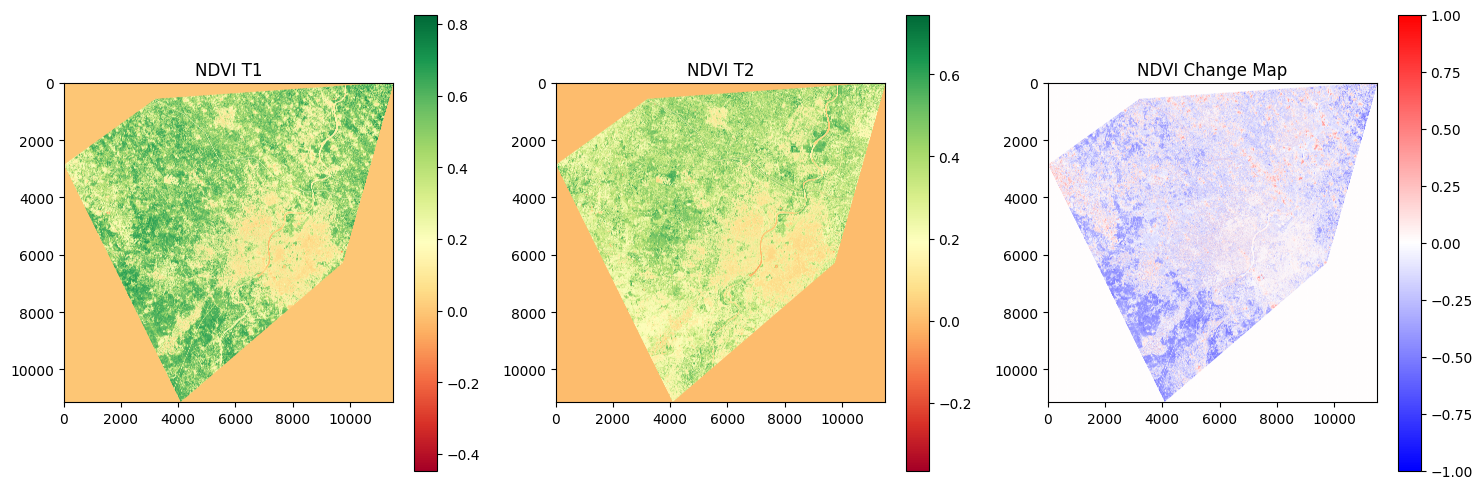

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('NDVI T1')
plt.imshow(ndvi_t1, cmap='RdYlGn')
plt.colorbar()
plt.subplot(1,3,2)
plt.title('NDVI T2')
plt.imshow(ndvi_t2, cmap='RdYlGn')
plt.colorbar()
plt.subplot(1,3,3)
plt.title('NDVI Change Map')
plt.imshow(ndvi_diff, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.tight_layout()
plt.savefig('LISS-4-Satellite-imagery/output/NDVI_ChangeMap.png')
plt.show()
plt.imsave('LISS-4-Satellite-imagery/output/NDVI_T1.png', ndvi_t1, cmap='RdYlGn')
plt.imsave('LISS-4-Satellite-imagery/output/NDVI_T2.png', ndvi_t2, cmap='RdYlGn')
plt.imsave('LISS-4-Satellite-imagery/output/change_mask.png', change_mask, cmap='gray')

In [36]:
## 9. Convert Change Mask to GeoJSON

In [18]:
from shapely.geometry import shape
from rasterio.features import shapes
from tqdm import tqdm
import json

print("⏳ Extracting shapes from change mask...")

geoms = []
props = []

try:
    for i, (geom, val) in enumerate(tqdm(shapes(change_mask.astype(np.uint8), mask=change_mask, transform=transform))):
        if val == 1:
            shapely_geom = shape(geom)
            if shapely_geom.area >= MIN_AREA_PIXELS:
                geoms.append(shapely_geom)
                props.append({})
    print(f"✅ Extraction complete. Found {len(geoms)} valid change polygons.")

    if geoms:
        gdf_changes = gpd.GeoDataFrame(props, geometry=geoms, crs=aoi_gdf.crs)
        gdf_changes.to_file(output_path, driver='GeoJSON')
        print(f"📁 GeoJSON file saved to: {output_path}")
    else:
        print("⚠ No valid polygons detected (after filtering).")
        
    with open('output/aoi.geojson', 'r') as f:
        geojson_data = json.load(f)
        print(json.dumps(geojson_data, indent=2))

except Exception as e:
    print("❌ Error during vectorization/export:", str(e))

⏳ Extracting shapes from change mask...
❌ Error during vectorization/export: name 'transform' is not defined


In [22]:
## 10. Save Output Rasters

In [23]:
def save_raster(path, array, profile):
    with rasterio.open(path, 'w', **profile) as dst:
        dst.write(array, 1)
save_raster('LISS-4-Satellite-imagery/output/NDVI_T1.tif', ndvi_t1.astype('float32'), clipped_t1['profile'])
save_raster('LISS-4-Satellite-imagery/output/NDVI_T2.tif', ndvi_t2.astype('float32'), clipped_t2['profile'])
save_raster('LISS-4-Satellite-imagery/output/ChangeMap.tif', ndvi_diff.astype('float32'), clipped_t1['profile'])